In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
import torch.nn.functional as F

#### Data

In [10]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', 
                                             train=True, 
                                             download=True, 
                                             transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=1024, 
                                          num_workers=10, 
                                          shuffle=True, 
                                          drop_last=True)

testset = torchvision.datasets.FashionMNIST(root='data', 
                                            train=False, 
                                            download=True, 
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1024, 
                                         num_workers=10, 
                                         shuffle=False)

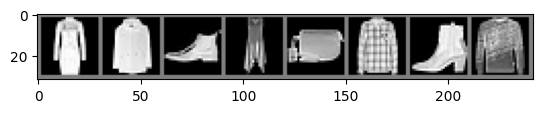

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [12]:
import torch
import torch.nn as nn
from torchsummary import summary

class ResizeLayer(nn.Module):
    def __init__(self, scale_factor, mode='bilinear', align_corners=False):
        super(ResizeLayer, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=5)
        self.resize = ResizeLayer(0.5)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(12*12*32, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.resize(x)
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

model = CustomModel()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
       ResizeLayer-3           [-1, 32, 12, 12]               0
           Flatten-4                 [-1, 4608]               0
            Linear-5                  [-1, 128]         589,952
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.26
Estimated Total Size (MB): 2.62
----------------------------------------------------------------


#### Loss, Optimizer, and Evaluation Function

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=1e-4)

In [14]:
def evaluate(model, testloader, loss_fn):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

#### Train

In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 20

In [16]:
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    train_accuracies.append(epoch_accuracy)

    epoch_loss = running_loss / (i + 1)
    train_losses.append(epoch_loss)
    
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Loss: 1.3961, Accuracy: 64.39%, Test Loss: 0.8738, Test Accuracy: 72.40%
Epoch [2/20], Loss: 0.7376, Accuracy: 75.26%, Test Loss: 0.6716, Test Accuracy: 76.45%
Epoch [3/20], Loss: 0.6132, Accuracy: 78.46%, Test Loss: 0.5985, Test Accuracy: 78.53%
Epoch [4/20], Loss: 0.5544, Accuracy: 80.46%, Test Loss: 0.5555, Test Accuracy: 80.30%
Epoch [5/20], Loss: 0.5158, Accuracy: 81.82%, Test Loss: 0.5267, Test Accuracy: 81.37%
Epoch [6/20], Loss: 0.4887, Accuracy: 82.89%, Test Loss: 0.5069, Test Accuracy: 81.99%
Epoch [7/20], Loss: 0.4671, Accuracy: 83.72%, Test Loss: 0.4850, Test Accuracy: 82.83%
Epoch [8/20], Loss: 0.4481, Accuracy: 84.35%, Test Loss: 0.4728, Test Accuracy: 83.18%
Epoch [9/20], Loss: 0.4338, Accuracy: 84.84%, Test Loss: 0.4567, Test Accuracy: 84.02%
Epoch [10/20], Loss: 0.4209, Accuracy: 85.31%, Test Loss: 0.4467, Test Accuracy: 84.30%
Epoch [11/20], Loss: 0.4103, Accuracy: 85.72%, Test Loss: 0.4366, Test Accuracy: 84.63%
Epoch [12/20], Loss: 0.3999, Accuracy: 86

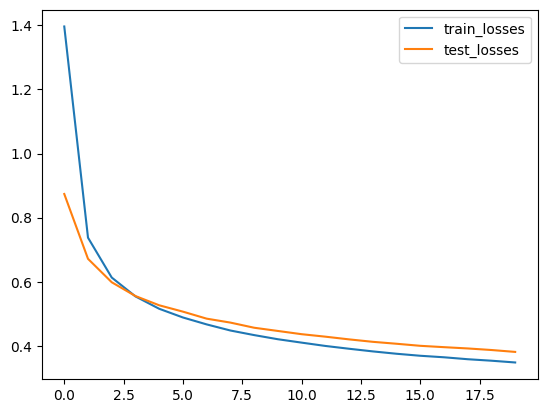

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

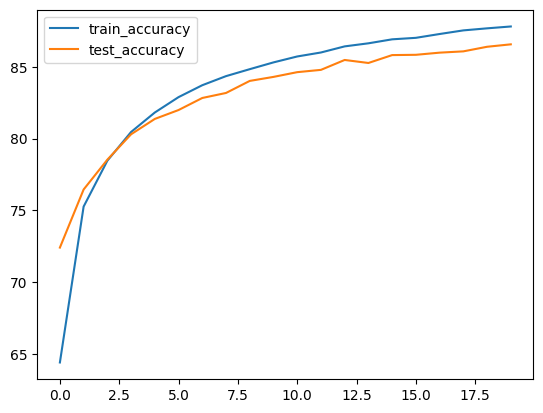

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()